# 前置作業

### 用Quantlib算的價格

In [1]:
import QuantLib as ql

maturity_date = ql.Date(30, 9, 2020)
spot_price = 100
strike_price = 100
volatility = (0.25+0.30)/2  # the historical vols for a year
dividend_rate =  0
option_type = ql.Option.Call

risk_free_rate = (0.025+0.028)/2
day_count = ql.Actual365Fixed()
calendar = ql.Taiwan()

calculation_date = ql.Date(1, 1, 2020)
ql.Settings.instance().evaluationDate = calculation_date

In [2]:
payoff = ql.PlainVanillaPayoff(option_type, strike_price)
exercise = ql.EuropeanExercise(maturity_date)
european_option = ql.VanillaOption(payoff, exercise)

In [3]:
spot_handle = ql.QuoteHandle(
    ql.SimpleQuote(spot_price)
)
flat_ts = ql.YieldTermStructureHandle(
    ql.FlatForward(calculation_date, risk_free_rate, day_count)
)
dividend_yield = ql.YieldTermStructureHandle(
    ql.FlatForward(calculation_date, dividend_rate, day_count)
)
flat_vol_ts = ql.BlackVolTermStructureHandle(
    ql.BlackConstantVol(calculation_date, calendar, volatility, day_count)
)
bsm_process = ql.BlackScholesMertonProcess(spot_handle, 
                                           dividend_yield, 
                                           flat_ts, 
                                           flat_vol_ts)

In [4]:
european_option.setPricingEngine(ql.AnalyticEuropeanEngine(bsm_process))
bs_price = european_option.NPV()
print ("The theoretical price is ", bs_price)

The theoretical price is  10.38651266481682


In [5]:
european_option.delta()

0.5801410058585631

In [6]:
print("Option value =", european_option.NPV())
print("Delta value  =", european_option.delta())
print("Theta value  =", european_option.theta())
print("Theta perday =", european_option.thetaPerDay())
print("Gamma value  =", european_option.gamma())
print("Vega value   =", european_option.vega())
print("Rho value    =", european_option.rho())

Option value = 10.38651266481682
Delta value  = 0.5801410058585631
Theta value  = -7.476472080013835
Theta perday = -0.020483485150722836
Gamma value  = 0.016434620826727357
Vega value   = 33.80353859086455
Rho value    = 35.62282603409256


# 自己算的版本Vanilla Option Price

## Option Price

In [7]:
import numpy as np
from scipy import stats

In [8]:
# 作業的參數
S=100
K=100
volatility = (0.25+0.30)/2
risk_free_rate = (0.025+0.028)/2
T=9/12

In [9]:
# d_1 = (np.log(S/K)+T*(risk_free_rate+0.5*volatility*volatility))/ (volatility*np.sqrt(T) )

In [10]:
# d_2 = d_1-(volatility*np.sqrt(T) )

In [11]:
# bs_price_handmade = S*stats.norm.cdf(d_1)-K*np.exp(-risk_free_rate*T)*stats.norm.cdf(d_2)

In [12]:
def BlackScholes(S=100, K=100, r=(0.025+0.028)/2, T=9/12, vol=(0.25+0.30)/2, option='call'):
    d_1 = (np.log(S/K)+T*(r+0.5*vol*vol))/ (vol*np.sqrt(T) )
    d_2 = d_1-(volatility*np.sqrt(T) )
    if option=='call':
        bs_price_handmade = S*stats.norm.cdf(d_1)-K*np.exp(-risk_free_rate*T)*stats.norm.cdf(d_2)
    elif option=='put':
        bs_price_handmade = K*np.exp(-risk_free_rate*T)*stats.norm.cdf(-d_2)   -  S*stats.norm.cdf(-d_1)
    
    return bs_price_handmade

In [13]:
print ("The calculated call option price is ", BlackScholes())
print ("The calculated put option price is ", BlackScholes(option='put'))

The calculated call option price is  10.401866039649548
The calculated put option price is  8.43398661955353


# 求Delta

 ### 差分

In [64]:
def BS_delta(delta=0.01, option='call'):
    return (BlackScholes(S=100+delta, option=option)-BlackScholes(option=option) )  /  delta

In [65]:
print ("The calculated call option delta by numeric is ", BS_delta())
print ("The calculated put option delta by numeric is ", BS_delta(option='put'))

The calculated call option delta by numeric is  0.5803315700305234
The calculated put option delta by numeric is  -0.4196684299685671


### 公式解

Call: $N(d_1)$

Put:$-N(-d_1)=N(d1)-1$

In [16]:
def BS_delta_fomula(S=100, K=100, r=(0.025+0.028)/2, T=9/12, vol=(0.25+0.30)/2, option='call'):
    d_1 = (np.log(S/K)+T*(r+0.5*vol*vol))/ (vol*np.sqrt(T) )
    if option=='call':
        delta = stats.norm.cdf(d_1)
    elif option=='put':
        delta = -stats.norm.cdf(-d_1)
    return delta

In [17]:
print ("The calculated call option delta by formula is ", BS_delta_fomula())
print ("The calculated put option delta by formula is ", BS_delta_fomula(option='put'))

The calculated call option delta by formula is  0.580249519243984
The calculated put option delta by formula is  -0.419750480756016


#  求Vega

### 差分

In [18]:
def BS_vega(delta=0.01, option='call'):
    return (BlackScholes(vol=(0.25+0.30)/2+delta, option=option)-BlackScholes(option=option) )  /  delta

In [19]:
BS_vega(.0001)

-7.823999226275191e-06

### 數字很奇怪，所以畫圖分析看看問題

In [20]:
a= np.linspace(-0.05,0.5,200)

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

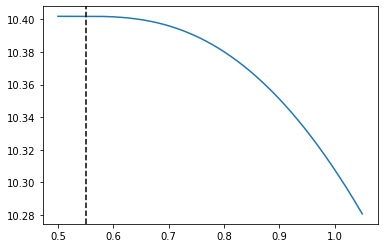

In [22]:
sns.lineplot(y= BlackScholes(vol= (0.25+0.30)/2+a), x=a+(0.25+0.30))
plt.axvline(0.25+0.30, linestyle='--', color='k')

還是不知道怎麼處理所以改用公式解

## 公式解

#### $ν = S\sqrt{T} \phi(d_1)$

Both identical for call and put

In [23]:
# S*np.sqrt(T)*stats.norm.pdf(d_1)

In [24]:
def BS_vega_formula(S=100, K=100, r=(0.025+0.028)/2, T=9/12, vol=(0.25+0.30)/2):
    d_1 = (np.log(S/K)+T*(r+0.5*vol*vol))   / (vol*np.sqrt(T))
    return S*np.sqrt(T)*stats.norm.pdf(d_1)

In [25]:
BS_vega_formula()

33.848038180051155

In [26]:
print ("The calculated put and call option vega by formula is ", BS_vega_formula())

The calculated put and call option vega by formula is  33.848038180051155


#  求Gamma

### 差分:用Delta公式來差分

In [27]:
def BS_gamma_fomula(S=100, K=100, r=(0.025+0.028)/2, T=9/12, vol=(0.25+0.30)/2, option='call', delta=0.01):
    d_1 = (np.log(S/K)+T*(r+0.5*vol*vol))/ (vol*np.sqrt(T) )
    d_2 = (np.log((S+delta)/K)+T*(r+0.5*vol*vol))/ (vol*np.sqrt(T) )
    if option=='call':
        gamma = (stats.norm.cdf(d_2) - stats.norm.cdf(d_1)) / delta
    elif option=='put':
        gamma = (-stats.norm.cdf(-d_2) - (-stats.norm.cdf(-d_1)))  / delta
    return gamma

In [28]:
print ("The calculated call option gamma by formula is ", BS_gamma_fomula())
print ("The calculated put option gamma by formula is ", BS_gamma_fomula(option='put'))

The calculated call option gamma by formula is  0.016409651316495744
The calculated put option gamma by formula is  0.016409651316506846


### 公式解

### $\frac{N'(d_1)}{S\sigma\sqrt{T}}$

In [29]:
def BS_gamma_formula(S=100, K=100, r=(0.025+0.028)/2, T=9/12, vol=(0.25+0.30)/2):
    d_1 = (np.log(S/K)+T*(r+0.5*vol*vol))   / (vol*np.sqrt(T))
    return stats.norm.pdf(d_1)/(S*vol*np.sqrt(T))

In [30]:
BS_gamma_formula()

0.016411170026691468

# 解Basel問題

## Q1.一大型先進經濟體電信股股票歐式陽春型 Call 選擇權，賣出 1000 股部位。請問此部位需計提多少市場風險資本?

### 參數設定

In [31]:
S = 100
K = 100
T = 9 / 12

r_1 = 0.02
r_3 = 0.0225
r_6 = 0.025
r_12 = 0.028

sigma6 = 0.25
sigma12 = 0.3

### 用內插法簡易計算9個月的r以及9個月的volitility

In [32]:
r_9 = (r_6+r_12)/2
sigma9 = (sigma6+sigma12)/2

### Delta部分

根據 Basel 文件(MAR 21.77, p57)，大型先進市場電信股票權數為 35%

Delta 風險量乘上風險權數(Risk Weight)，求得加權敏感性(Weighted Sensitivity)

$WS_k = RW_k \times s_k$

In [33]:
Kb_delta = BS_delta() *0.35*1000
Kb_delta

203.11604951068318

### Vega部分

$s_k = vega \times implied\, volatility$

$WS_k = RW_k \times s_k$

In [34]:
Kb_vega = 0.35*BS_vega_formula()*sigma9*1000
Kb_vega

3257.8736748299234

###  Curvature 部分

In [35]:
CVR_Pos = -(BlackScholes(S=100+0.35*100, option='call')-BlackScholes(S=100, option='call')- 0.35 * BS_delta())
CVR_Pos

-27.493477347394276

In [36]:
CVR_Neg = -(BlackScholes(S=100-0.35*100, option='call')-BlackScholes(S=100, option='call') + 0.35 * BS_delta())
CVR_Neg

9.873747323762592

In [37]:
Kb_pos = np.sqrt(max(0, max(CVR_Pos, 0)**2))
Kb_pos

0.0

In [38]:
Kb_neg = np.sqrt(max(0, max(CVR_Neg, 0)**2))
Kb_neg

9.873747323762592

In [39]:
Kb= max(Kb_pos, Kb_neg)

In [40]:
Kb_Curv = Kb*1000
Kb_Curv

9873.74732376259

In [41]:
print("From Delta : {} \nFrom Vega : {} \nFrom Curvature: {} \n\nTotal : {}".format(Kb_delta, Kb_vega, Kb_Curv, \
                                                                            Kb_delta + Kb_vega + Kb_Curv))

print("標的資產價格 : 100,000\n自有資本計提率: {:%}".format(( Kb_delta + Kb_vega + Kb_Curv)/100000))

From Delta : 203.11604951068318 
From Vega : 3257.8736748299234 
From Curvature: 9873.74732376259 

Total : 13334.737048103198
標的資產價格 : 100,000
自有資本計提率: 13.334737%


## Q2.在Q1的條件下，同時再加入一個同樣條件的Put選擇權，則共需多少自有資金?

In [59]:
#Price
print(BlackScholes())
print(BlackScholes(option='put'))

10.401866039649548
8.43398661955353


### Delta部分

In [43]:
Delta_Call = BS_delta() *0.35*1000
Delta_Call

203.11604951068318

In [44]:
Delta_Put = BS_delta(option='put') *0.35*1000
Delta_Put

-146.8839504889985

In [45]:
Kb_delta = np.sqrt( max(0, Delta_Call**2 + Delta_Put**2 + 2 *Delta_Call *  Delta_Put) )

In [46]:
Kb_delta

56.232099021684725

### Vega部分

In [47]:
Vega_call = 0.35*BS_vega_formula()*sigma9*1000
Vega_call

3257.8736748299234

In [48]:
Vega_put = 0.35*BS_vega_formula()*sigma9*1000
Vega_put

3257.8736748299234

In [49]:
rho = min (1 * np.exp(-1* 0/1), 1)
rho

1.0

In [50]:
Kb_vega = np.sqrt( max(0, Vega_call**2 + Vega_put**2 + 2 *Vega_call *  Vega_put) )
Kb_vega

6515.747349659847

### Curvature部分

In [51]:
CVR_Pos = -(BlackScholes(S=100+0.35*100, option='call')-BlackScholes(S=100, option='call')- 0.35 * BS_delta()+\
            BlackScholes(S=100+0.35*100, option='put')-BlackScholes(S=100, option='put')- 0.35 * BS_delta()
           )
CVR_Pos

-19.986954694788555

In [52]:
CVR_Neg = -(BlackScholes(S=100-0.35*100, option='call')-BlackScholes(S=100, option='call') + 0.35 * BS_delta()+\
           BlackScholes(S=100-0.35*100, option='put')-BlackScholes(S=100, option='put') + 0.35 * BS_delta()
           )
CVR_Neg

-15.25250535247482

In [53]:
Kb_pos = np.sqrt(max(0, max(CVR_Pos, 0)**2))
Kb_pos

0.0

In [54]:
Kb_neg = np.sqrt(max(0, max(CVR_Neg, 0)**2))
Kb_neg

0.0

In [55]:
Kb= max(Kb_pos, Kb_neg)

In [56]:
Kb_Curv = Kb*1000
Kb_Curv

0.0

In [58]:
print("From Delta : {} \nFrom Vega : {} \nFrom Curvature: {} \n\nTotal : {}".format(Kb_delta, Kb_vega, Kb_Curv, \
                                                                            Kb_delta + Kb_vega + Kb_Curv))

print("標的資產價格 : 200,000\n自有資本計提率: {:%}".format(( Kb_delta + Kb_vega + Kb_Curv)/200000))

From Delta : 56.232099021684725 
From Vega : 6515.747349659847 
From Curvature: 0.0 

Total : 6571.979448681532
標的資產價格 : 200,000
自有資本計提率: 3.285990%
